![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark MIOST North Atlantic Lagrangian Cumulative Distance

<div style="text-align: right"><i> 2023-04-27 DUACS_SSH_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of MIOST sea surface height maps</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by the DUACS system. </h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the trajectories of independent drifters distributed by CMEMS </h5>
</div>

# 1. Import packages

In [1]:
import os
import numpy as np
import xarray as xr
#from xmovie import Movie
import matplotlib
import matplotlib.pylab as plt
#import cartopy.crs as ccrs
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker 
#from conv_glo2 import read_drifters
from scipy.interpolate import RegularGridInterpolator
import cmocean
import pickle
import gc
from matplotlib import cm 
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_traj import *
from src.mod_compare import regional_zoom

# 2. Setup parameters

In [3]:
method_name = 'MIOST_NAtl'

time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-12-31'                                        # time max for analysis 

dir_out = f'../results/'                               # output directory path 
prefix_out = 'dict_drifter_adv'
results_out = 'deviat_uv_'+method_name+'.nc'

if not os.path.exists(dir_out):
    os.system('mkdir '+dir_out)

# Gulf Stream region
region = 'NAtl'
lon_min = 280                                          # domain min longitude
lon_max = 359                                          # domain max longitude
lat_min = 0.                                          # domain min latitude
lat_max = 55.                                          # domain max latitude 


# 3. Maps to evaluate

## 3.1 Download maps

In [8]:
path_maps =  f'../data/maps/MIOST_geos_global_allsat-alg/dt*.nc'

maps = xr.open_mfdataset(path_maps) 

maps['longitude'] = xr.where(
    maps['longitude'] < 0,
    maps['longitude'] + 360,
    maps['longitude']) 

maps = maps.sel({'longitude':slice(lon_min-0.5,lon_max+0.5)})
maps = maps.sel({'latitude':slice(lat_min-0.5,lat_max+0.5)}) 
maps

<xarray.Dataset>
Dimensions:    (longitude: 801, latitude: 560, time: 365)
Coordinates:
  * longitude  (longitude) float64 279.5 279.6 279.7 279.8 ... 359.3 359.4 359.5
  * latitude   (latitude) float32 -0.45 -0.35 -0.25 -0.15 ... 55.25 55.35 55.45
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 560, 801), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 560, 801), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 560, 801), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 560, 801), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 560, 801), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 560, 801), meta=np.ndarray>

## 3.2 Retrieve maps info 

In [10]:
time = maps.time.values
lon = maps.longitude.values
lat = maps.latitude.values 

time = (time.astype('datetime64[h]') - np.datetime64('2019-01-01')).astype(int)
Nt = time[-1] 

u_maps = maps.ugos
v_maps = maps.vgos

U_maps = (u_maps**2+v_maps**2)**0.5

# 4. Independant drifters

## 4.1 Download drifters

In [7]:
path_drifters = '../data/independent_drifters/uv*'
ds_drifters = xr.open_mfdataset(path_drifters,concat_dim='time',combine='nested')
ds_drifters

<xarray.Dataset>
Dimensions:    (time: 2156405)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    latitude   (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(5559,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(5559,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               116275
    date_update:                 2020-10-13T12:17:40Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              -58.44
    last_longitude_observation:  82.75
    last_latitude_observation:   -18.49
    date_drog_lost:              2017-01-21T03:37:00Z
    death_type:                  stop transmitting
    last_date_observation:       2019-01-16T01:51:00Z

## 4.2 Prepare drifter data

In [11]:
%%time
ind, time_drifter, lon_drifter, lat_drifter, id_drifter= prepare_drifter_data(ds_drifters,maps)

CPU times: user 1min 50s, sys: 14.8 s, total: 2min 5s
Wall time: 1min 52s


# 5. Interpolate maps at drifters locations


In [12]:
%%time
fu = RegularGridInterpolator((time, lat, lon), u_maps.values)
fv = RegularGridInterpolator((time, lat, lon), v_maps.values)

CPU times: user 37.4 s, sys: 12 s, total: 49.3 s
Wall time: 51.6 s


# 6. Artificial drifter trajectories 

## 6.1 Trajectory parameters and initialization 

In [13]:
nday = 5
dt_h = 24 
mode = 'euler' 
write = False 
Np = time_drifter.size

horizons = np.arange(0,nday*24/dt_h+1)

dict_drifter_adv_maps = {0:{'time':time_drifter,
                           'lon':lon_drifter,
                           'lat':lat_drifter,
                            'id':id_drifter}
                       }
horizons

array([0., 1., 2., 3., 4., 5.])

## 6.2 Compute trajectories

In [14]:
%%time
dict_drifter_adv_maps = compute_traj(dict_drifter_adv_maps, horizons, fu, fv ,Np, Nt, dt_h, method_name, dir_out, prefix_out, mode, write)


h 1.0
h 2.0.0
h 3.0.0
h 4.0.0
h 5.0.0
CPU times: user 11min 15s, sys: 13 s, total: 11min 28s
Wall time: 12min 10s


# 7. Compute deviation  

In [15]:
# Deviation = Cumulative distance between artificial and real trajectories

# Average deviation by bins
lon_out=np.arange(lon_min, lon_max, 1)
lat_out=np.arange(lat_min, lat_max, 1)

horizon_days = [1,2,3,4,5]
    
dev_maps, var_dev_maps, dmean = compute_deviation(dict_drifter_adv_maps, Nt, dt_h, horizon_days,lon_out,lat_out, dir_out, method_name, results_out)


# 8. Plots

## 8.1 Plot deviation maps at different horizons

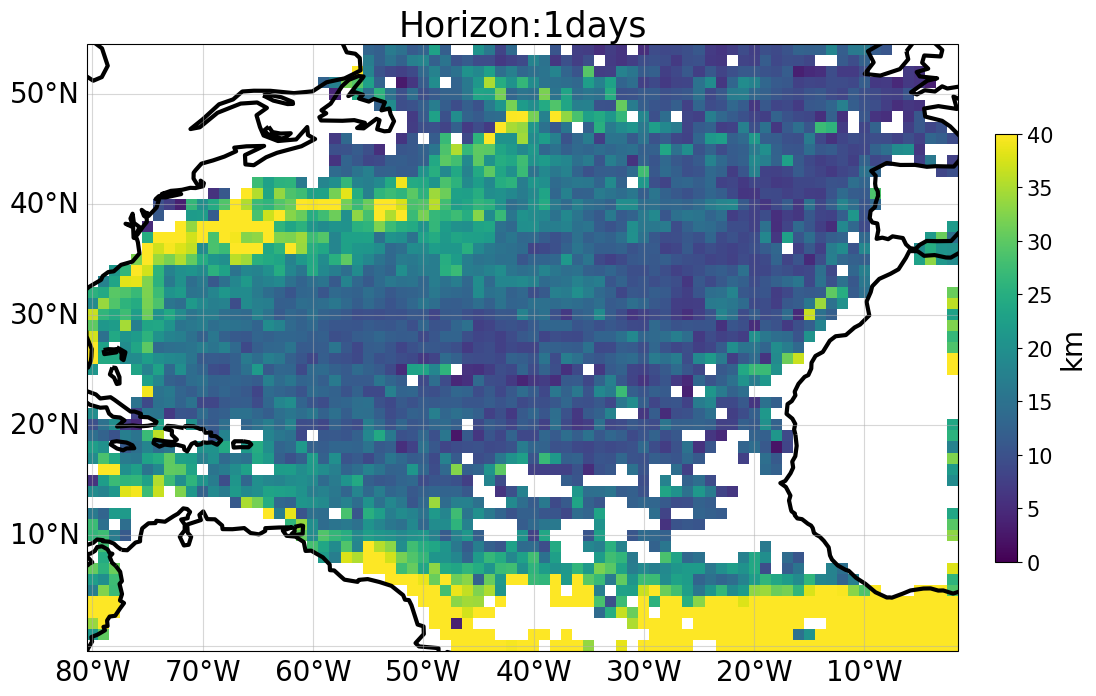

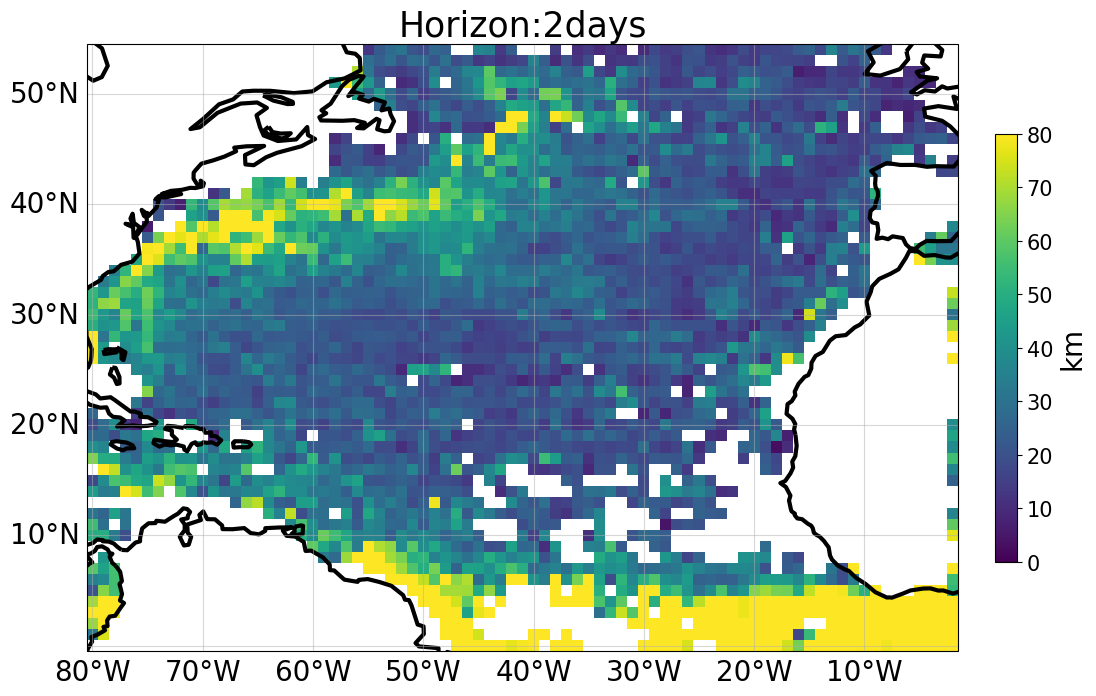

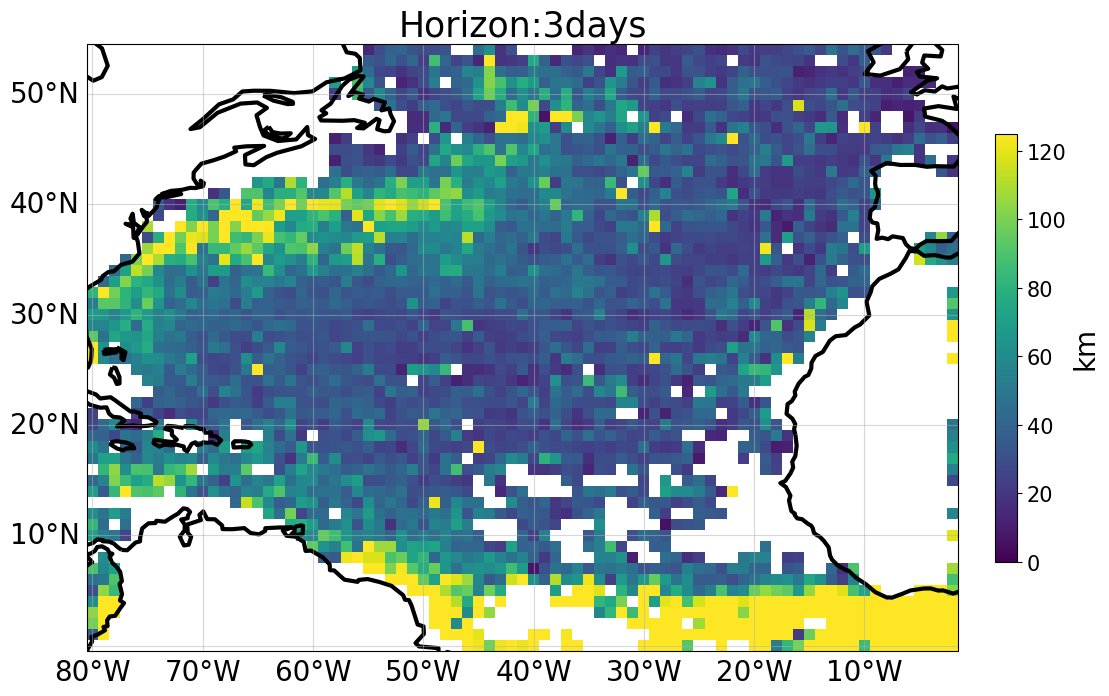

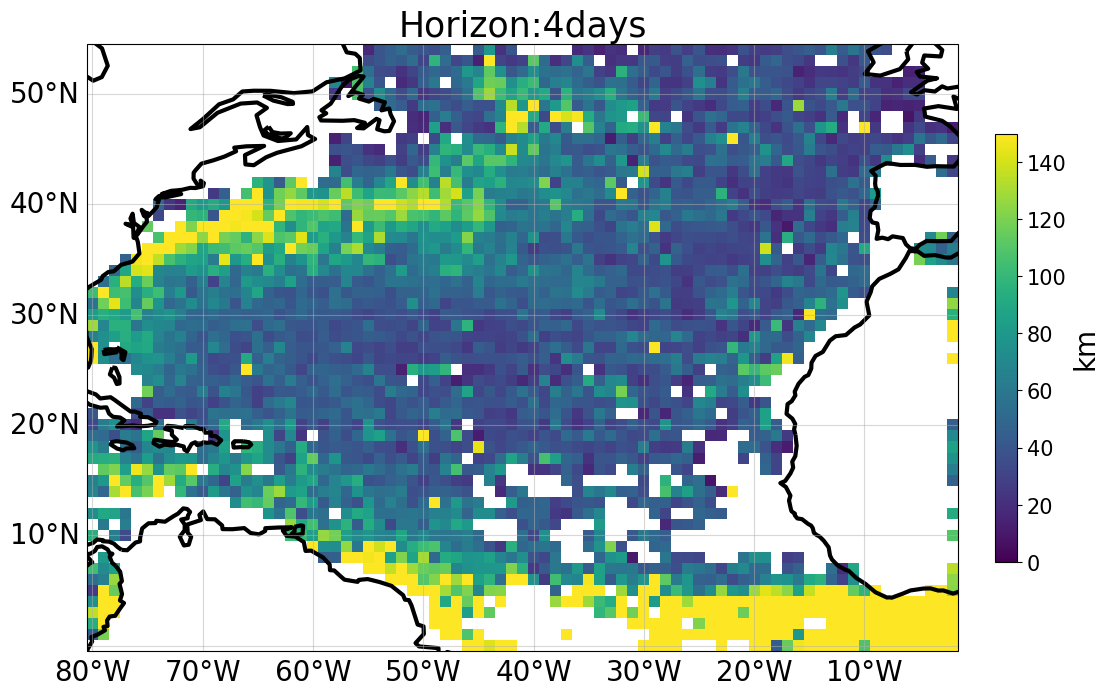

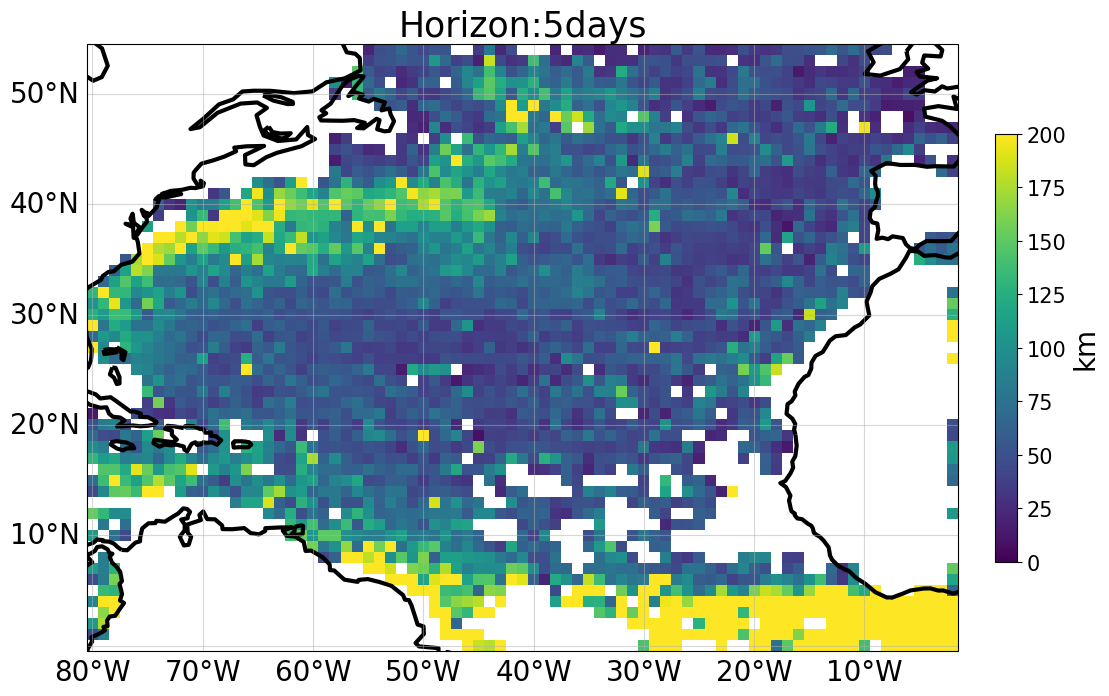

In [16]:
horizon_plots = [1,2,3,4,5]
horizon_plot_max = [40,80,125,150,200]

plot_traj_deviation_maps( lon_out, lat_out, dev_maps, dt_h,horizon_plots,horizon_plot_max,method_name) 


## 8.2 Plot spatially averaged deviation as a function of horizons

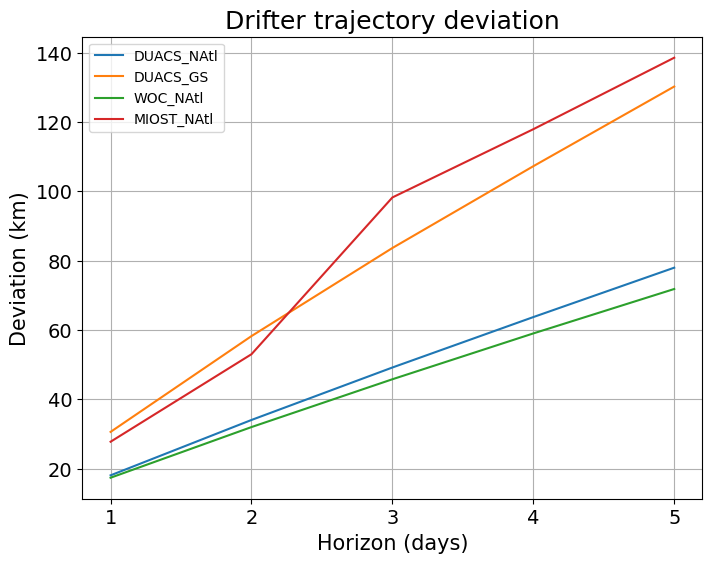

In [18]:
plot_meantraj_deviation(dir_out)

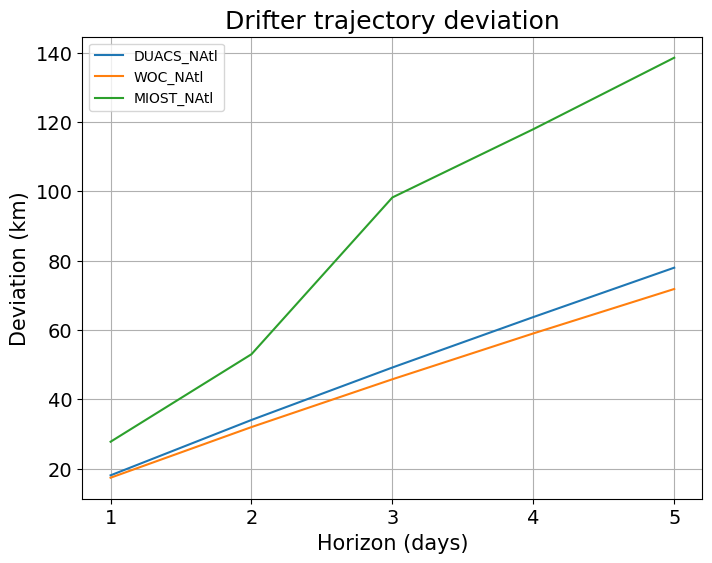

In [20]:
plot_meantraj_deviation(dir_out, just_basin='NAtl')